## Final Project Submission

Please fill out:
* Student name: Aleigha (Aly) Sardina-Spevack
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Eli Thomas
* Blog post URL: TBD


# New York Stock Exchange

Long have analysts, traders, and investors tried to predict future stock prices.  Even if you come up with a plan or model that works for a while, it is generally great until for some reason it doesn't work.  Whether there was a break down in underlying correlations or new news of scandal caused stock price to plummet.  If you could crack the whole code you'd be a bilionaire in about the same amout of time as it takes to click on your favorite Netflix program.  

If any type of model is going to be able to finally do it, I would be willing to bet that model would fall into the deep learning category.  So that is exactly what we are going to try to do.

## The Data

The data set we will be working with is from the New York Stock Exhange (NYSE) and represent the historical prices and other fundamental data points of the S&P 500 from 2010 to the end 2016.


Dataset consists of following files:

prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
securities.csv: general description of each company with division on sectors
fundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

The majority of our focus will be on the prices-split-adjusted.csv file, as this contains the adjusted prices for the stocks we will be trying to predict.

## The Process

In General, we will follow the Data Science process, Cleaning, Exploring, and Analyzing iteratively until we arive at a useable model.  

As always we can begin by importing all the necessary libraries for our notebook.

In [98]:
import numpy as np
import pandas as pd
import math
#import keras
import datetime
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='whitegrid')
sns.set_palette('Set1')

In [3]:
#Making new data directories
#only run once or you will receive an error
test_folder ='split/test/'
train_folder = 'split/train/'
val_folder ='split/validation/'
split ='split/'

folders = [split, val_folder, train_folder, test_folder]

for folder in folders:
    os.mkdir(folder)

In [6]:
# import all stock prices 
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


There are some really great metrics and facinating exploration we can do with what we have in this dataframe.  We'll start with some basic summary statitics and move forward to more exploration.

Lets see how many stocks there are in our dataset.

In [7]:
print("There are {} stocks.".format(len(set(df.symbol))))

There are 501 stocks.


In [137]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


This is a really fun to see the whole population of the S&P 500.  The smalled stock in the S&P 500 had a low of 1.50 per share and the most expensive stock for this time frame was 1,600.93 per share.  Other than volume, we can see how the other metics might be a little skewed given the standard deviation is actually greater than the mean price.  With one stock strading at 1.50 and another over 1,600, that's not really comparing apples to apples!  

We can look at some price and volume movements for a single stock next.  Let's have a look at Citigroup, the Bank Holding Company that owns Citibank, N.A.

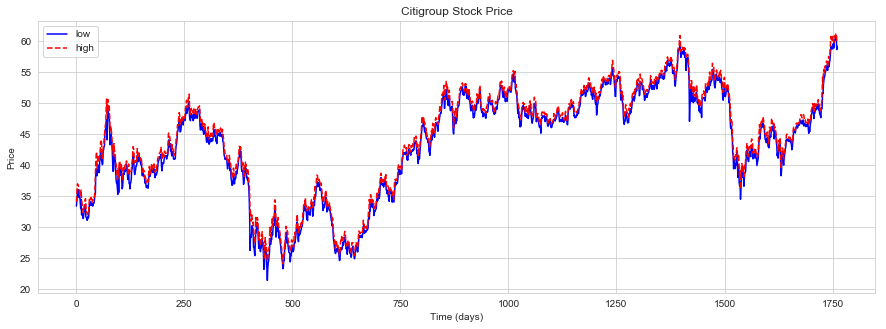

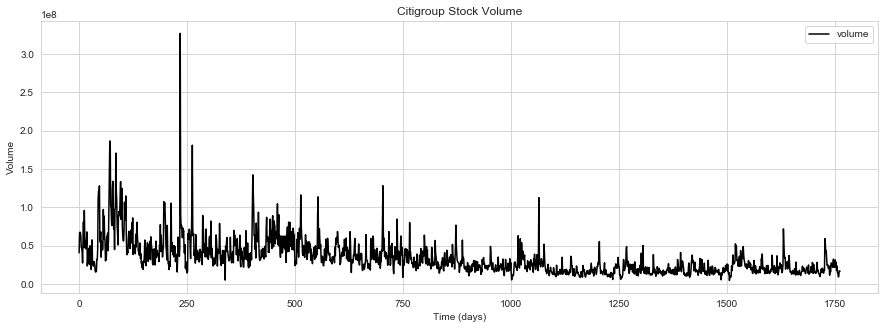

In [99]:
plt.figure(figsize=(15, 5));

plt.plot(df[df.symbol == 'C'].low.values, color='blue',linestyle = '-', label='low')
plt.plot(df[df.symbol == 'C'].high.values, color='red',linestyle = '--', label='high')
plt.title('Citigroup Stock Price')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(df[df.symbol == 'C'].volume.values, color='black', label='volume')
plt.title('Citigroup Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.show()

Interesting, it looks like Citigroup's volume of trades per day decreased stadily as the company rebounded from its lower points in this period. 


This didn't happen in a vaccum, so we can take a slice of the data and look at a number of metrics to get a feel for what the economy looked like and try to see if there were any idiosyncratic hiccups in any one particular stock that belied news particular to the company or industry.

A caution: While the NYSE can be thought of as a proxy for the very general health of the economy and the S&P 500 can be thought of as a general proxy for the NYSE, we should be cognizant of generalizations and their impact on our analysis.  Our analysis shouldn't really be affected in this regard, but it is worth noting for anyone thinking about the bigger picture. 


Let's review the first 50 stocks and see what their high points looked like in this period

In [33]:
def get_max_high(sym):
    highs = df[df['symbol'] == sym].high.values
    return(max(highs))

In [36]:
highs = []
stocks = list(set(df.symbol))
for sym in stocks:
    highs.append(get_max_high(sym))

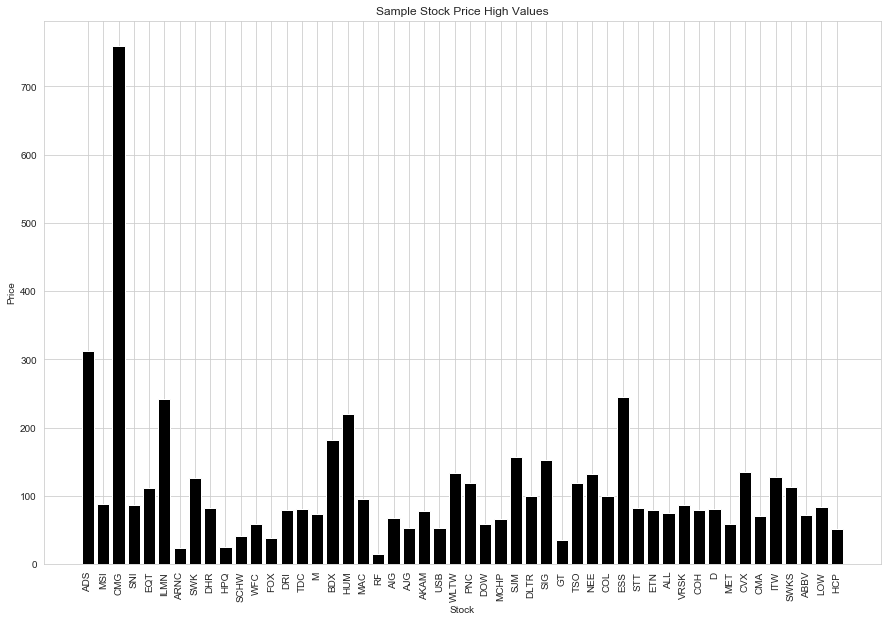

In [100]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price High Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

Of course, we can do the same for lows.

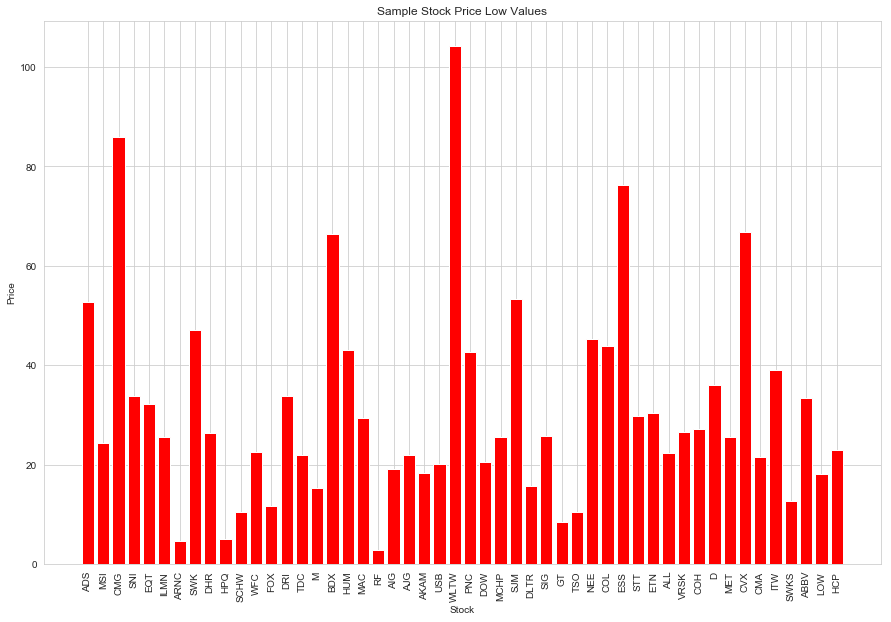

In [101]:
def get_min_low(sym):
    lows = df[df['symbol'] == sym].low.values
    return(min(lows))
lows = []
for sym in stocks:
    lows.append(get_min_low(sym))
    
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Low Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

We can layer these two visualizations together to see the absolute variability of the stocks.

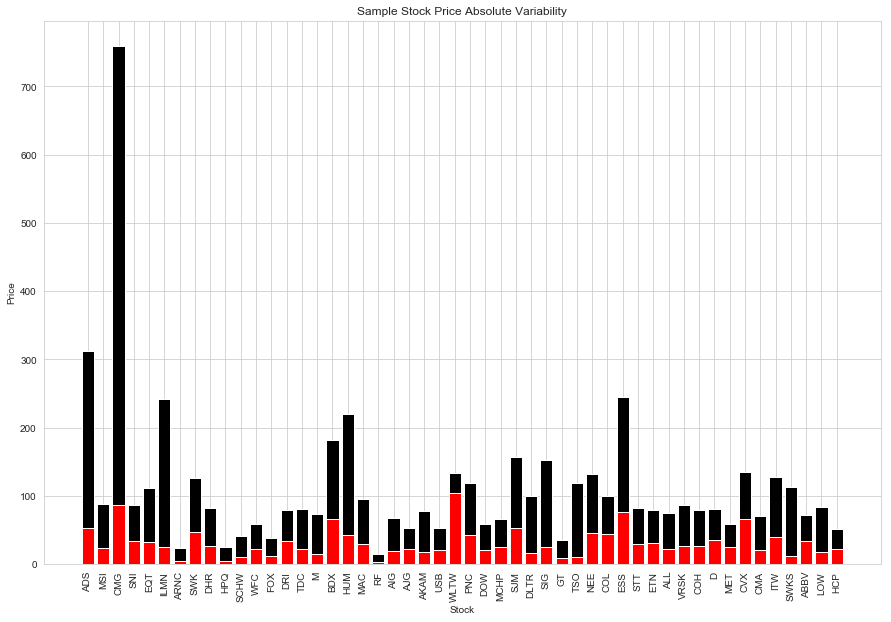

In [138]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Absolute Variability')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

Look at Chipotle ('CMG')! The stock went from under 100 to nearly 800 per share.  Let's see exactly what the highs and lows were.

In [146]:
high_cmg = []
low_cmg = []


low_cmg.append(get_min_low('CMG'))
high_cmg.append(get_max_high('CMG'))

print("Chipotle's maximum price is {}.".format(round(high_cmg[0],1)))
print("Chipotle's minimum price is {}.".format(round(low_cmg[0],1)))

Chipotle's maximum price is 758.6.
Chipotle's minimum price is 86.0.


This type of analysis would be really useful for risk management.  It gives an idea of recent volatility and may begin to allow the investment analyst to form opinion on wehter the stock is a Buy, Hold, or Sell.  Some trading positions and onvestment portfolios require volitility minimums and maximums and seeing such wide swings may indicate that the shorter term models that are typical may not be capturing all the risk.   

Let's look at January 2015 now for further exploration.  We can plot the total trade volume byt stock on each Friday in January.  

In [88]:
jan2= df.loc['2015-01-02']
jan2_vol = jan2.volume.values

jan9= df.loc['2015-01-09']
jan9_vol = jan9.volume.values

jan16= df.loc['2015-01-16']
jan16_vol = jan16.volume.values

jan23= df.loc['2015-01-23']
jan23_vol = jan23.volume.values

jan30= df.loc['2015-01-30']
jan30_vol = jan30.volume.values



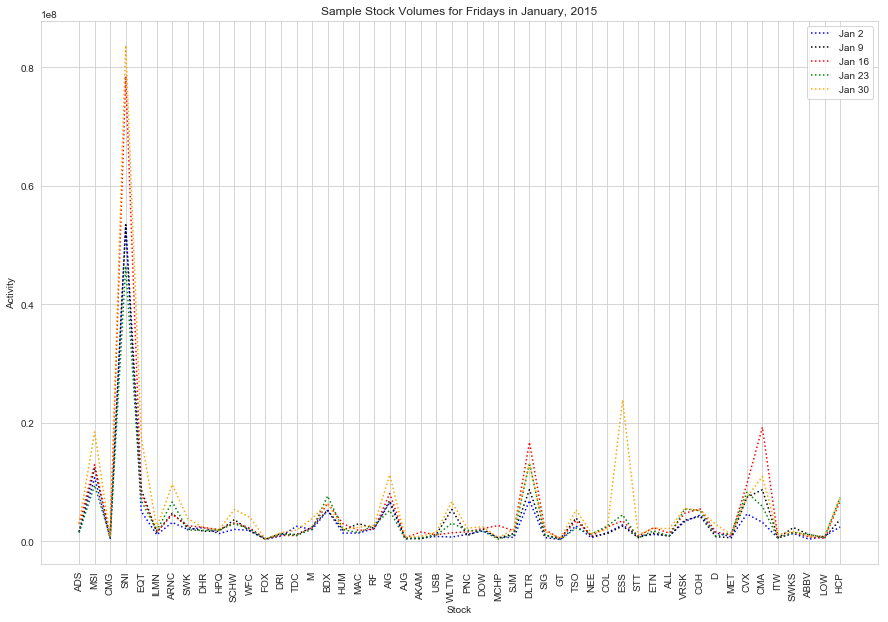

In [148]:
plt.figure(figsize=(15,10))
plt.plot(stocks[:50], jan2_vol[:50],color='blue',linestyle = ':',label='Jan 2')
plt.plot(stocks[:50], jan9_vol[:50],color='black',linestyle = ':',label='Jan 9')
plt.plot(stocks[:50], jan16_vol[:50],color='red',linestyle = ':',label='Jan 16')
plt.plot(stocks[:50], jan23_vol[:50],color='green',linestyle = ':',label='Jan 23')
plt.plot(stocks[:50], jan30_vol[:50],color='orange',linestyle = ':',label='Jan 30')

plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Volumes for Fridays in January, 2015' )
plt.ylabel('Activity')
plt.xlabel('Stock')
plt.legend(loc='best')
plt.show()

There are a few things that I would like to point out as interesting here.  First let's look at EES, or the WisdomTree U.S. SmallCap Fund.  It's an ETF that seeks to track the investment results of earnings-generating small-cap companies in the U.S. equity market.  There was a surge of activity with EES on January 30th compared to other Friday's in January. The second pattern that I want to point out is the last Friday (and business day) of the month has the most volume.  This is actually much clearer if we convert this to a bar graph.

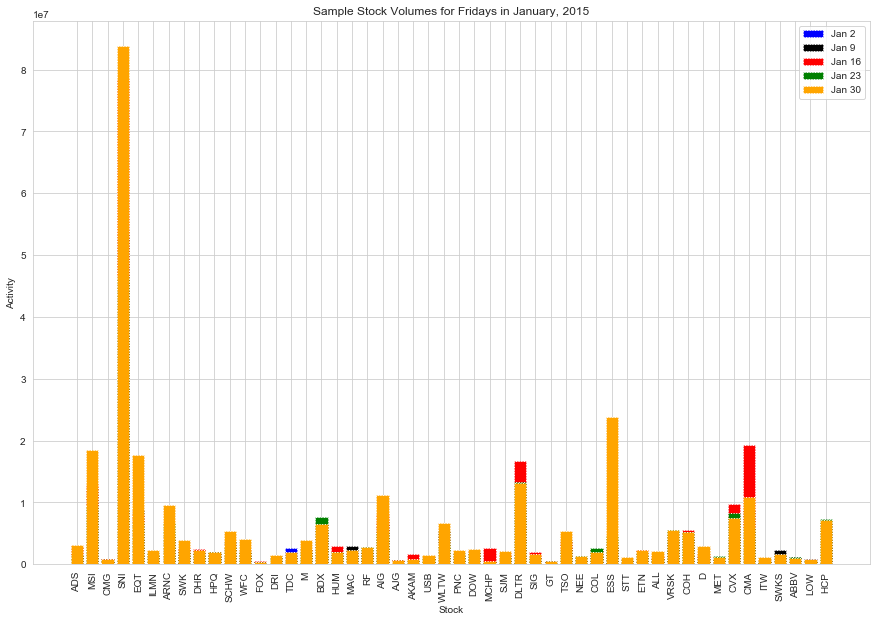

In [149]:
plt.figure(figsize=(15,10))
plt.bar(stocks[:50], jan2_vol[:50],color='blue',linestyle = ':',label='Jan 2')
plt.bar(stocks[:50], jan9_vol[:50],color='black',linestyle = ':',label='Jan 9')
plt.bar(stocks[:50], jan16_vol[:50],color='red',linestyle = ':',label='Jan 16')
plt.bar(stocks[:50], jan23_vol[:50],color='green',linestyle = ':',label='Jan 23')
plt.bar(stocks[:50], jan30_vol[:50],color='orange',linestyle = ':',label='Jan 30')

plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Volumes for Fridays in January, 2015' )
plt.ylabel('Activity')
plt.xlabel('Stock')
plt.legend(loc='best')
plt.show()

The January effect of stocks (where prices tend to rebound in January after lower prices in December) is likely driving more volume.  Appreciating capital likes company.  And secondly, year-end bonuses (including stock options) tend to pay out at the end of January and there is a rush of cash into the markets.

open and close

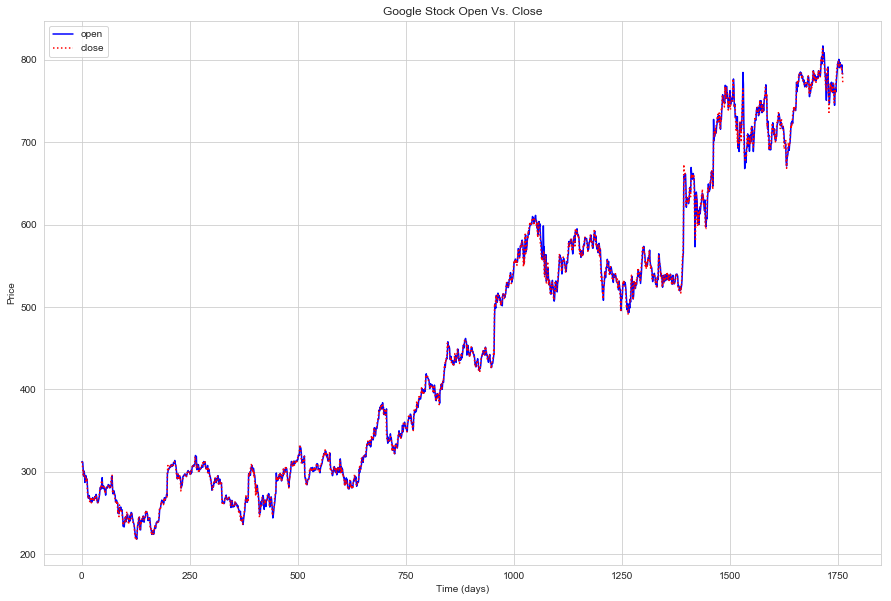

In [130]:
plt.figure(figsize=(15, 10));

plt.plot(df[df.symbol == 'GOOG'].open.values, color='blue',linestyle = '-', label='open')
plt.plot(df[df.symbol == 'GOOG'].close.values, color='red',linestyle = ':', label='close')
plt.title('Google Stock Open Vs. Close')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

work on modeling one stock but we can compare it to a few in the same industry

goog
aapl
msft


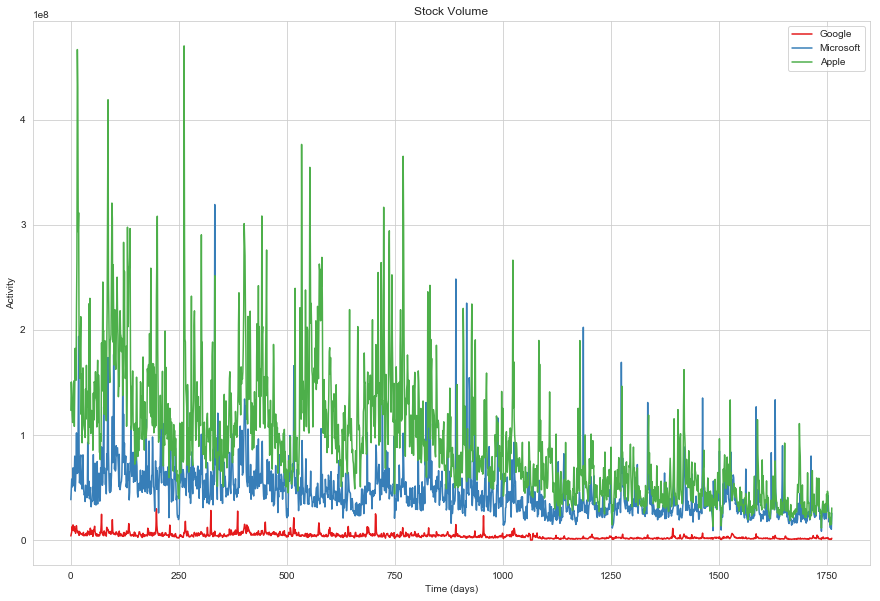

In [135]:
plt.figure(figsize=(15, 10));
sns.set_palette("Set1")
plt.plot(df[df.symbol == 'GOOG'].volume.values,linestyle = '-', label='Google')
plt.plot(df[df.symbol == 'MSFT'].volume.values,linestyle = '-', label='Microsoft')
plt.plot(df[df.symbol == 'AAPL'].volume.values,linestyle = '-', label='Apple')
plt.title('Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

calculate var? ie value at risk

turn to preprocessing the data

min max scaling to ensure smoother results and better performance
